# Prediction du prix des appartements — DVF

**Objectif** : Predire le prix de vente (`valeur_fonciere`) des appartements en France a partir des donnees DVF (Demandes de Valeurs Foncieres).

## 1. Chargement et exploration des donnees

In [2]:
# Imports
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.inspection import permutation_importance

sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", 50)

In [3]:
# Chargement de tous les fichiers CSV du dossier datasets/
data_dir = Path("datasets")
csv_files = sorted(data_dir.glob("full_*.csv"))
print(f"Fichiers trouves : {[f.name for f in csv_files]}")

# Colonnes utiles pour limiter la memoire
COLS = [
    "id_mutation", "date_mutation", "nature_mutation", "valeur_fonciere",
    "code_postal", "code_commune", "nom_commune", "code_departement",
    "type_local", "surface_reelle_bati", "nombre_pieces_principales",
    "surface_terrain", "nombre_lots",
    "lot1_surface_carrez", "lot2_surface_carrez",
    "longitude", "latitude",
]

frames = []
for f in csv_files:
    print(f"Chargement de {f.name}...")
    tmp = pd.read_csv(f, usecols=COLS, low_memory=False)
    frames.append(tmp)

df_raw = pd.concat(frames, ignore_index=True)
print(f"\nDataset brut : {df_raw.shape[0]:,} lignes x {df_raw.shape[1]} colonnes")

Fichiers trouves : ['full_2020.csv', 'full_2021.csv', 'full_2022.csv', 'full_2023.csv', 'full_2024.csv', 'full_2025.csv']
Chargement de full_2020.csv...
Chargement de full_2021.csv...
Chargement de full_2022.csv...
Chargement de full_2023.csv...
Chargement de full_2024.csv...
Chargement de full_2025.csv...

Dataset brut : 20,102,739 lignes x 17 colonnes


In [4]:
# Apercu des donnees
df_raw.head()

,id_mutation,date_mutation,nature_mutation,valeur_fonciere,code_postal,code_commune,nom_commune,code_departement,lot1_surface_carrez,lot2_surface_carrez,nombre_lots,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude
0,2020-1,2020-07-01,Vente,31234.16,1560.0,01367,Saint-Julien-sur-Reyssouze,01,NaN,NaN,0,NaN,NaN,NaN,1192.0,5.109255,46.403019
1,2020-2,2020-07-01,Vente,278000.00,1250.0,01125,Corveissiat,01,NaN,NaN,0,NaN,NaN,NaN,10092.0,5.444577,46.252372
2,2020-2,2020-07-01,Vente,278000.00,1250.0,01125,Corveissiat,01,NaN,NaN,0,NaN,NaN,NaN,4570.0,5.444588,46.253467
3,2020-2,2020-07-01,Vente,278000.00,1250.0,01125,Corveissiat,01,NaN,NaN,0,NaN,NaN,NaN,5750.0,5.442015,46.256031
4,2020-2,2020-07-01,Vente,278000.00,1250.0,01408,Simandre-sur-Suran,01,NaN,NaN,0,NaN,NaN,NaN,648170.0,5.439915,46.250795


In [5]:
# Informations generales
df_raw.info()

<class 'pandas.DataFrame'>
RangeIndex: 20102739 entries, 0 to 20102738
Data columns (total 17 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   id_mutation                str    
 1   date_mutation              str    
 2   nature_mutation            str    
 3   valeur_fonciere            float64
 4   code_postal                float64
 5   code_commune               str    
 6   nom_commune                str    
 7   code_departement           str    
 8   lot1_surface_carrez        float64
 9   lot2_surface_carrez        float64
 10  nombre_lots                int64  
 11  type_local                 str    
 12  surface_reelle_bati        float64
 13  nombre_pieces_principales  float64
 14  surface_terrain            float64
 15  longitude                  float64
 16  latitude                   float64
dtypes: float64(9), int64(1), str(7)
memory usage: 2.5 GB


In [6]:
# Statistiques descriptives
df_raw.describe()

,valeur_fonciere,code_postal,lot1_surface_carrez,lot2_surface_carrez,nombre_lots,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude
count,1.990835e+07,1.995114e+07,1.772926e+06,570300.000000,2.010274e+07,6.855855e+06,1.187762e+07,1.370536e+07,1.967936e+07,1.967936e+07
mean,1.541231e+06,4.997526e+04,6.728769e+01,63.955231,4.351320e-01,1.158278e+02,1.817896e+00,2.873838e+03,2.365772e+00,4.609840e+01
std,1.684142e+07,2.740071e+04,2.070255e+02,68.614400,8.438582e-01,8.408068e+02,2.085038e+00,1.880021e+04,6.372190e+00,5.925143e+00
min,1.000000e-02,1.000000e+03,1.000000e-02,0.010000,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,-6.315108e+01,-2.138654e+01
25%,6.870000e+04,2.817000e+04,3.574000e+01,43.710000,0.000000e+00,5.000000e+01,0.000000e+00,2.490000e+02,3.381075e-01,4.466201e+01
50%,1.650000e+05,4.915000e+04,5.513000e+01,61.510000,0.000000e+00,7.500000e+01,1.000000e+00,6.250000e+02,2.369637e+00,4.670934e+01
75%,3.052900e+05,7.500600e+04,7.416000e+01,76.660000,1.000000e+00,1.050000e+02,3.000000e+00,1.797000e+03,4.658078e+00,4.866632e+01
max,1.415000e+10,9.749000e+04,9.614000e+03,8705.000000,2.360000e+02,5.934000e+05,1.980000e+02,4.353772e+07,5.583079e+01,5.108645e+01


In [7]:
# Valeurs manquantes par colonne
missing = df_raw.isnull().sum()
missing_pct = (missing / len(df_raw) * 100).round(2)
pd.DataFrame({"manquantes": missing, "pourcentage": missing_pct}).sort_values("pourcentage", ascending=False)

,manquantes,pourcentage
lot2_surface_carrez,19532439,97.16
lot1_surface_carrez,18329813,91.18
surface_reelle_bati,13246884,65.90
nombre_pieces_principales,8225123,40.92
type_local,8212317,40.85
surface_terrain,6397378,31.82
longitude,423376,2.11
latitude,423376,2.11
valeur_fonciere,194390,0.97
code_postal,151600,0.75


## 2. Filtrage et nettoyage

- Filtrer : uniquement les **Ventes** d'**Appartements**
- Supprimer les `valeur_fonciere` manquantes ou aberrantes (< 10 000 EUR ou > 10 000 000 EUR)
- Supprimer les surfaces incoherentes (surface <= 0 ou > 500 m2)
- Dedupliquer les mutations multi-lots
- Gerer les valeurs manquantes

In [8]:
# 2a. Filtrer : Ventes d'Appartements uniquement
print(f"Avant filtrage : {len(df_raw):,} lignes")
print(f"nature_mutation : {df_raw['nature_mutation'].value_counts().to_dict()}")
print(f"type_local      : {df_raw['type_local'].value_counts().to_dict()}")

df = df_raw[
    (df_raw["nature_mutation"] == "Vente")
    & (df_raw["type_local"] == "Appartement")
].copy()
print(f"\nApres filtre Vente + Appartement : {len(df):,} lignes")

Avant filtrage : 20,102,739 lignes
nature_mutation : {'Vente': 18638601, "Vente en l'état futur d'achèvement": 1117091, 'Echange': 230743, 'Vente terrain à bâtir': 55140, 'Adjudication': 52248, 'Expropriation': 8916}
type_local      : {'Dépendance': 4997746, 'Maison': 3370550, 'Appartement': 2876665, 'Local industriel. commercial ou assimilé': 645461}

Apres filtre Vente + Appartement : 2,737,070 lignes


In [9]:
# 2b. Supprimer valeur_fonciere manquante ou aberrante
df = df.dropna(subset=["valeur_fonciere"])
df = df[(df["valeur_fonciere"] >= 10_000) & (df["valeur_fonciere"] <= 10_000_000)]
print(f"Apres filtre valeur_fonciere [10k, 10M] : {len(df):,} lignes")

# 2c. Filtrer surfaces incoherentes
df = df[(df["surface_reelle_bati"] > 0) & (df["surface_reelle_bati"] <= 500)]
print(f"Apres filtre surface (0, 500] m2 : {len(df):,} lignes")

# 2d. Supprimer les doublons lies aux mutations multi-lots
# On garde une ligne par id_mutation (celle avec la plus grande surface)
df = df.sort_values("surface_reelle_bati", ascending=False).drop_duplicates(
    subset=["id_mutation"], keep="first"
)
print(f"Apres deduplication par id_mutation : {len(df):,} lignes")

# 2e. Supprimer lignes sans coordonnees GPS
df = df.dropna(subset=["longitude", "latitude"])
print(f"Apres suppression sans GPS : {len(df):,} lignes")

# 2f. Remplir nombre_pieces_principales manquant par la mediane
df["nombre_pieces_principales"] = df["nombre_pieces_principales"].fillna(
    df["nombre_pieces_principales"].median()
)

# Liberer la memoire
del df_raw, frames
print(f"\nDataset nettoye final : {len(df):,} lignes")

Apres filtre valeur_fonciere [10k, 10M] : 2,590,041 lignes
Apres filtre surface (0, 500] m2 : 2,589,725 lignes
Apres deduplication par id_mutation : 2,067,103 lignes
Apres suppression sans GPS : 2,043,775 lignes

Dataset nettoye final : 2,043,775 lignes


## 3. Feature engineering

- Extraction temporelle : annee, mois, trimestre
- Prix au m2 (pour analyse exploratoire)
- Surface Carrez : surface du lot principal si disponible
- Target encoding du departement (prix moyen par departement)

In [10]:
# 3a. Extraction temporelle
df["date_mutation"] = pd.to_datetime(df["date_mutation"])
df["annee"] = df["date_mutation"].dt.year
df["mois"] = df["date_mutation"].dt.month
df["trimestre"] = df["date_mutation"].dt.quarter

# 3b. Prix au m2 (indicateur exploratoire)
df["prix_m2"] = df["valeur_fonciere"] / df["surface_reelle_bati"]

# 3c. Surface Carrez du lot principal (remplir par 0 si absente)
df["surface_carrez"] = df["lot1_surface_carrez"].fillna(0)

# 3d. Target encoding du departement
dept_mean = df.groupby("code_departement")["valeur_fonciere"].mean()
df["dept_prix_moyen"] = df["code_departement"].map(dept_mean)

print("Nouvelles colonnes :", ["annee", "mois", "trimestre", "prix_m2", "surface_carrez", "dept_prix_moyen"])
df[["date_mutation", "annee", "mois", "trimestre", "prix_m2", "surface_carrez", "dept_prix_moyen"]].head()

Nouvelles colonnes : ['annee', 'mois', 'trimestre', 'prix_m2', 'surface_carrez', 'dept_prix_moyen']


,date_mutation,annee,mois,trimestre,prix_m2,surface_carrez,dept_prix_moyen
16605075,2024-12-20,2024,12,4,2520.000000,0.00,170220.111978
2040887,2020-12-30,2020,12,4,13527.054108,0.00,630267.360839
6733960,2021-03-08,2021,3,1,18145.161290,528.31,630267.360839
17286870,2024-05-02,2024,5,2,285.714286,106.42,185364.371189
2434642,2021-04-08,2021,4,2,1396.303901,0.00,113153.537935


## 4. Analyse exploratoire (EDA)

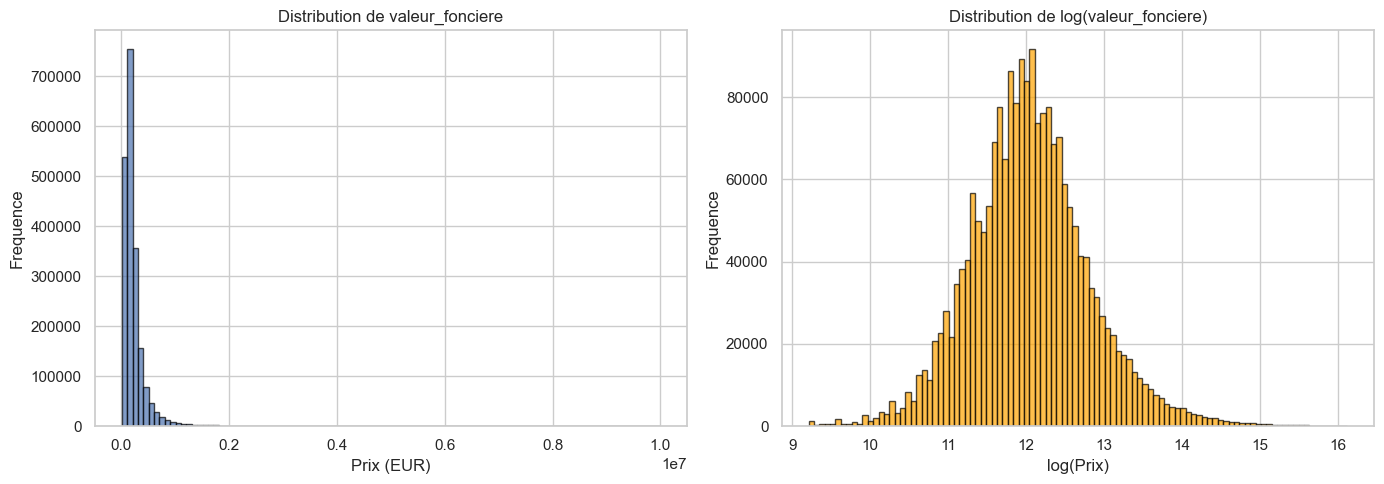

In [11]:
# Distribution de la variable cible
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df["valeur_fonciere"], bins=100, edgecolor="black", alpha=0.7)
axes[0].set_title("Distribution de valeur_fonciere")
axes[0].set_xlabel("Prix (EUR)")
axes[0].set_ylabel("Frequence")

axes[1].hist(np.log1p(df["valeur_fonciere"]), bins=100, edgecolor="black", alpha=0.7, color="orange")
axes[1].set_title("Distribution de log(valeur_fonciere)")
axes[1].set_xlabel("log(Prix)")
axes[1].set_ylabel("Frequence")

plt.tight_layout()
plt.show()

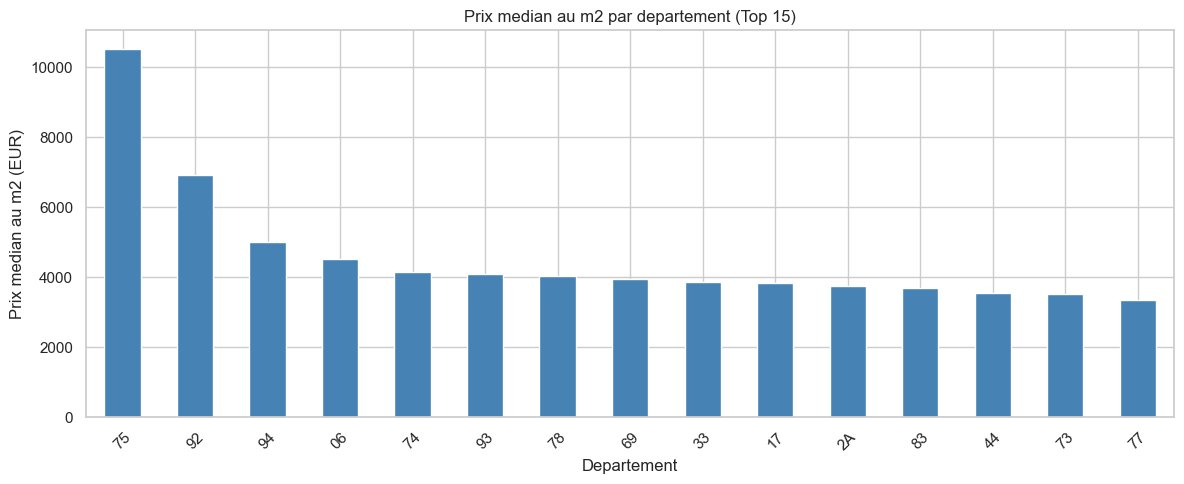

In [12]:
# Prix au m2 par departement — Top 15
top_dept = (
    df.groupby("code_departement")["prix_m2"]
    .median()
    .sort_values(ascending=False)
    .head(15)
)

fig, ax = plt.subplots(figsize=(12, 5))
top_dept.plot(kind="bar", ax=ax, color="steelblue")
ax.set_title("Prix median au m2 par departement (Top 15)")
ax.set_xlabel("Departement")
ax.set_ylabel("Prix median au m2 (EUR)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

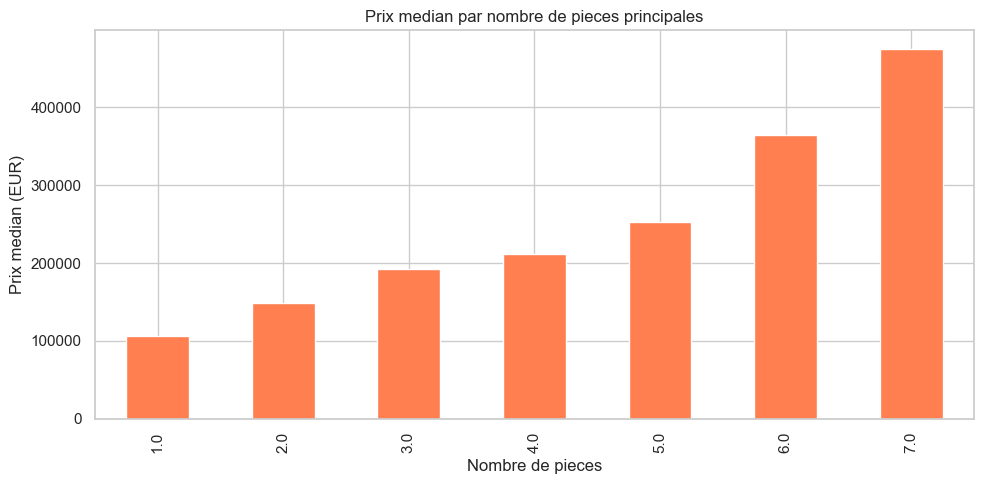

In [13]:
# Prix median par nombre de pieces
fig, ax = plt.subplots(figsize=(10, 5))
df.groupby("nombre_pieces_principales")["valeur_fonciere"].median().loc[1:7].plot(
    kind="bar", ax=ax, color="coral"
)
ax.set_title("Prix median par nombre de pieces principales")
ax.set_xlabel("Nombre de pieces")
ax.set_ylabel("Prix median (EUR)")
plt.tight_layout()
plt.show()

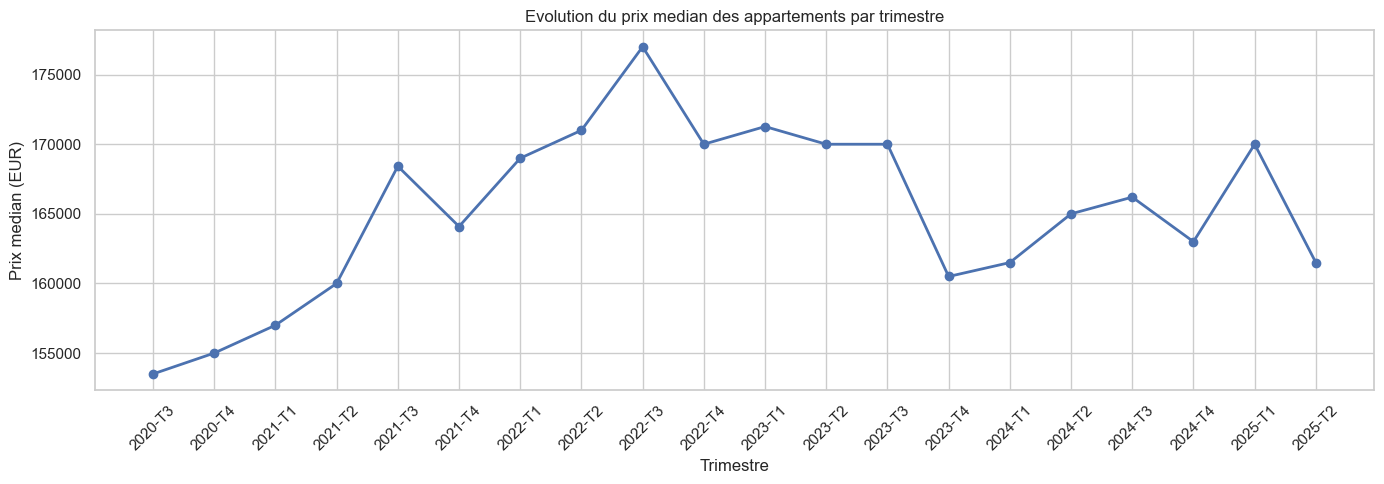

In [14]:
# Evolution du prix median par trimestre
prix_trim = df.groupby(["annee", "trimestre"])["valeur_fonciere"].median().reset_index()
prix_trim["periode"] = prix_trim["annee"].astype(str) + "-T" + prix_trim["trimestre"].astype(str)

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(prix_trim["periode"], prix_trim["valeur_fonciere"], marker="o", linewidth=2)
ax.set_title("Evolution du prix median des appartements par trimestre")
ax.set_xlabel("Trimestre")
ax.set_ylabel("Prix median (EUR)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

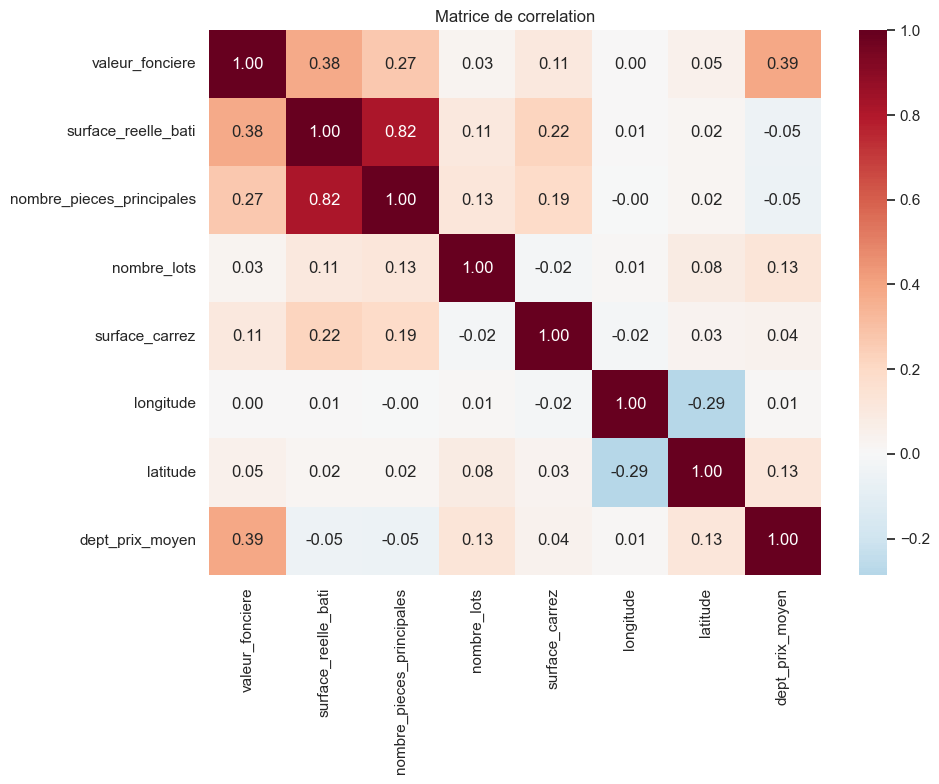

In [15]:
# Matrice de correlation des variables numeriques
num_cols = [
    "valeur_fonciere", "surface_reelle_bati", "nombre_pieces_principales",
    "nombre_lots", "surface_carrez", "longitude", "latitude", "dept_prix_moyen",
]
corr = df[num_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu_r", center=0, ax=ax)
ax.set_title("Matrice de correlation")
plt.tight_layout()
plt.show()

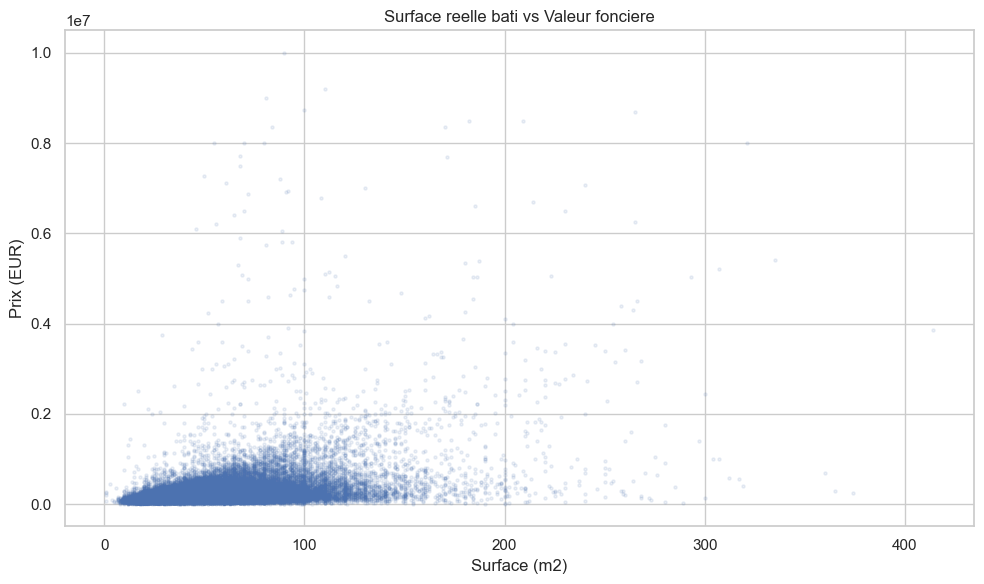

In [16]:
# Scatter : surface vs prix
fig, ax = plt.subplots(figsize=(10, 6))
sample = df.sample(min(50_000, len(df)), random_state=42)
ax.scatter(sample["surface_reelle_bati"], sample["valeur_fonciere"], alpha=0.1, s=5)
ax.set_title("Surface reelle bati vs Valeur fonciere")
ax.set_xlabel("Surface (m2)")
ax.set_ylabel("Prix (EUR)")
plt.tight_layout()
plt.show()

## 5. Preparation des donnees pour la modelisation

In [17]:
# Features selectionnees pour le modele
FEATURES = [
    "surface_reelle_bati",
    "nombre_pieces_principales",
    "nombre_lots",
    "surface_carrez",
    "longitude",
    "latitude",
    "annee",
    "mois",
    "trimestre",
    "dept_prix_moyen",
]
TARGET = "valeur_fonciere"

X = df[FEATURES].copy()
y = df[TARGET].copy()

print(f"X shape : {X.shape}")
print(f"y shape : {y.shape}")
print(f"\nValeurs manquantes dans X :\n{X.isnull().sum()}")

# Separation train / test (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"\nTrain : {X_train.shape[0]:,} lignes")
print(f"Test  : {X_test.shape[0]:,} lignes")

X shape : (2043775, 10)
y shape : (2043775,)

Valeurs manquantes dans X :
surface_reelle_bati          0
nombre_pieces_principales    0
nombre_lots                  0
surface_carrez               0
longitude                    0
latitude                     0
annee                        0
mois                         0
trimestre                    0
dept_prix_moyen              0
dtype: int64

Train : 1,635,020 lignes
Test  : 408,755 lignes


## 6. Modelisation

Modeles entraines :
1. **Regression lineaire** (baseline)
2. **Ridge** (regularisation L2)
3. **Lasso** (regularisation L1)
4. **Random Forest** (robuste aux outliers)
5. **HistGradientBoosting** (equivalent LightGBM integre a scikit-learn)

In [18]:
def evaluate_model(name, model, X_tr, y_tr, X_te, y_te):
    """Entraine un modele, calcule les metriques et retourne un dict de resultats."""
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    mae = mean_absolute_error(y_te, y_pred)
    rmse = np.sqrt(mean_squared_error(y_te, y_pred))
    r2 = r2_score(y_te, y_pred)

    print(f"--- {name} ---")
    print(f"  MAE  : {mae:,.0f} EUR")
    print(f"  RMSE : {rmse:,.0f} EUR")
    print(f"  R2   : {r2:.4f}")
    print()

    return {"modele": name, "MAE": mae, "RMSE": rmse, "R2": r2, "model_obj": model}

In [19]:
# Definir les modeles
models = {
    "Regression Lineaire": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=1.0, max_iter=5000),
    "Random Forest": RandomForestRegressor(
        n_estimators=200, max_depth=20, min_samples_leaf=10,
        n_jobs=-1, random_state=42,
    ),
    "HistGradientBoosting": HistGradientBoostingRegressor(
        max_iter=500, max_depth=10, learning_rate=0.1,
        min_samples_leaf=20, random_state=42,
    ),
}

# Entrainer et evaluer chaque modele
results = []
for name, model in models.items():
    res = evaluate_model(name, model, X_train, y_train, X_test, y_test)
    results.append(res)

--- Regression Lineaire ---
  MAE  : 117,098 EUR
  RMSE : 283,264 EUR
  R2   : 0.3146

--- Ridge ---
  MAE  : 117,098 EUR
  RMSE : 283,264 EUR
  R2   : 0.3146

--- Lasso ---
  MAE  : 117,098 EUR
  RMSE : 283,264 EUR
  R2   : 0.3146

--- Random Forest ---
  MAE  : 65,230 EUR
  RMSE : 218,047 EUR
  R2   : 0.5939

--- HistGradientBoosting ---
  MAE  : 71,454 EUR
  RMSE : 220,944 EUR
  R2   : 0.5830



## 7. Evaluation et comparaison des modeles

In [20]:
# Tableau recapitulatif
df_results = pd.DataFrame(results)[["modele", "MAE", "RMSE", "R2"]]
df_results_display = df_results.copy()
df_results_display["MAE"] = df_results_display["MAE"].map(lambda x: f"{x:,.0f}")
df_results_display["RMSE"] = df_results_display["RMSE"].map(lambda x: f"{x:,.0f}")
df_results_display["R2"] = df_results_display["R2"].map(lambda x: f"{x:.4f}")
df_results_display

,modele,MAE,RMSE,R2
0,Regression Lineaire,"117,098","283,264",0.3146
1,Ridge,"117,098","283,264",0.3146
2,Lasso,"117,098","283,264",0.3146
3,Random Forest,"65,230","218,047",0.5939
4,HistGradientBoosting,"71,454","220,944",0.5830


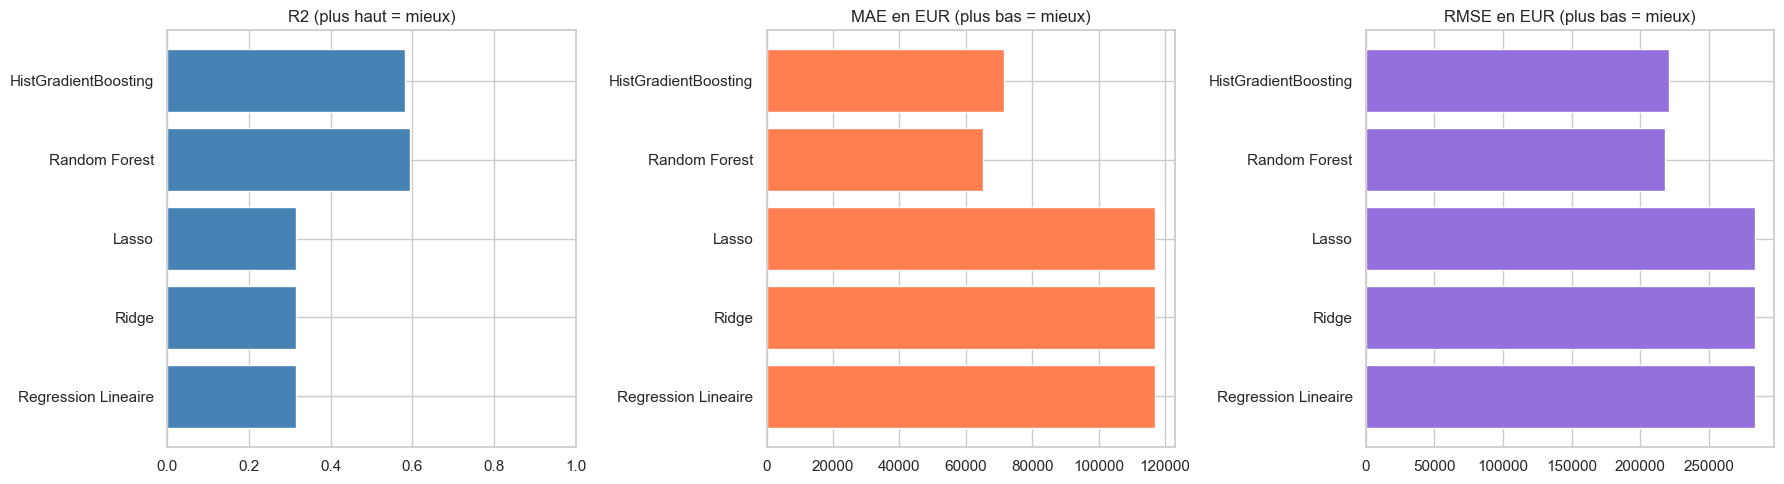

In [21]:
# Comparaison visuelle des metriques
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].barh(df_results["modele"], df_results["R2"], color="steelblue")
axes[0].set_title("R2 (plus haut = mieux)")
axes[0].set_xlim(0, 1)

axes[1].barh(df_results["modele"], df_results["MAE"], color="coral")
axes[1].set_title("MAE en EUR (plus bas = mieux)")

axes[2].barh(df_results["modele"], df_results["RMSE"], color="mediumpurple")
axes[2].set_title("RMSE en EUR (plus bas = mieux)")

plt.tight_layout()
plt.show()

In [22]:
# Validation croisee sur le meilleur modele
best_result = max(results, key=lambda r: r["R2"])
print(f"Meilleur modele : {best_result['modele']}")

best_model = best_result["model_obj"]

# Cross-validation 5-fold (sur un echantillon pour la vitesse si > 200k lignes)
if len(X) > 200_000:
    X_cv = X.sample(200_000, random_state=42)
    y_cv = y.loc[X_cv.index]
else:
    X_cv, y_cv = X, y

cv_scores = cross_val_score(
    best_model.__class__(**best_model.get_params()),
    X_cv, y_cv,
    cv=5, scoring="r2", n_jobs=-1,
)
print(f"\nCross-validation 5-fold R2 : {cv_scores}")
print(f"R2 moyen : {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

Meilleur modele : Random Forest

Cross-validation 5-fold R2 : [0.52039883 0.53209127 0.55133458 0.52473145 0.57200918]
R2 moyen : 0.5401 (+/- 0.0191)


C:\Users\girard\AppData\Local\Temp\ipykernel_32748\1329351595.py:14: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\girard\git\machine_learning\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


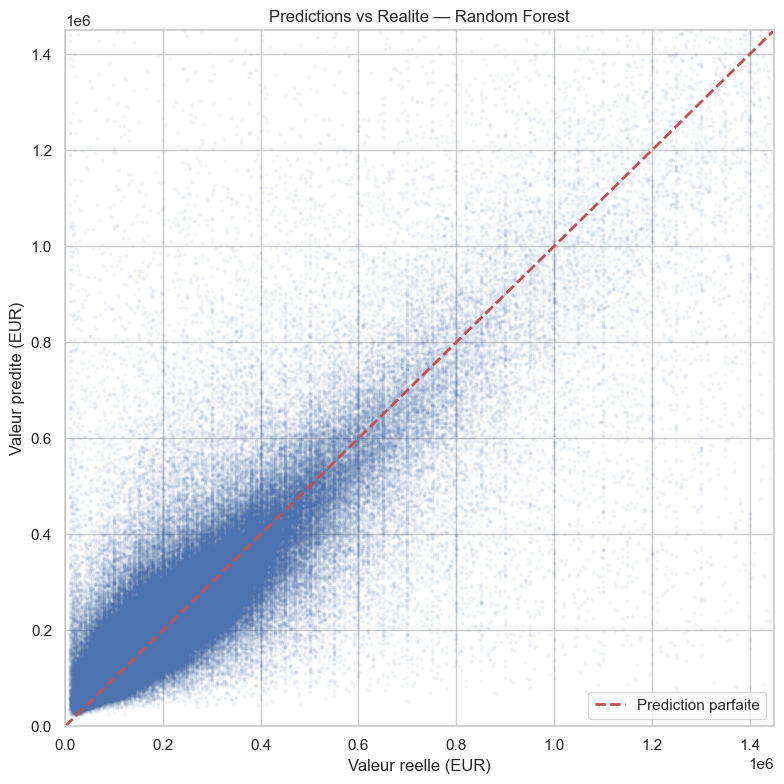

In [23]:
# Predictions vs valeurs reelles (meilleur modele)
y_pred_best = best_model.predict(X_test)

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(y_test, y_pred_best, alpha=0.05, s=3)
lims = [0, y_test.quantile(0.99)]
ax.plot(lims, lims, "r--", linewidth=2, label="Prediction parfaite")
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel("Valeur reelle (EUR)")
ax.set_ylabel("Valeur predite (EUR)")
ax.set_title(f"Predictions vs Realite — {best_result['modele']}")
ax.legend()
plt.tight_layout()
plt.show()

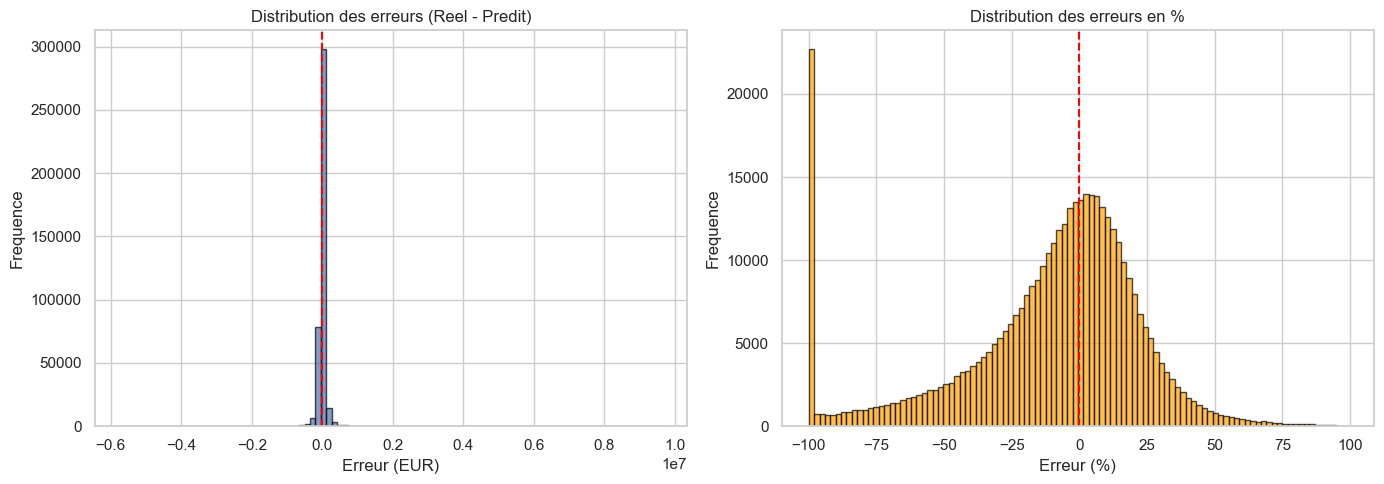

Erreur mediane absolue : 28,629 EUR
Erreur mediane en %    : 16.9 %


In [24]:
# Distribution des erreurs de prediction
errors = y_test - y_pred_best

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(errors, bins=100, edgecolor="black", alpha=0.7)
axes[0].axvline(0, color="red", linestyle="--")
axes[0].set_title("Distribution des erreurs (Reel - Predit)")
axes[0].set_xlabel("Erreur (EUR)")
axes[0].set_ylabel("Frequence")

pct_error = (errors / y_test * 100).clip(-100, 100)
axes[1].hist(pct_error, bins=100, edgecolor="black", alpha=0.7, color="orange")
axes[1].axvline(0, color="red", linestyle="--")
axes[1].set_title("Distribution des erreurs en %")
axes[1].set_xlabel("Erreur (%)")
axes[1].set_ylabel("Frequence")

plt.tight_layout()
plt.show()

print(f"Erreur mediane absolue : {np.median(np.abs(errors)):,.0f} EUR")
print(f"Erreur mediane en %    : {np.median(np.abs(pct_error)):.1f} %")

## 8. Importance des features

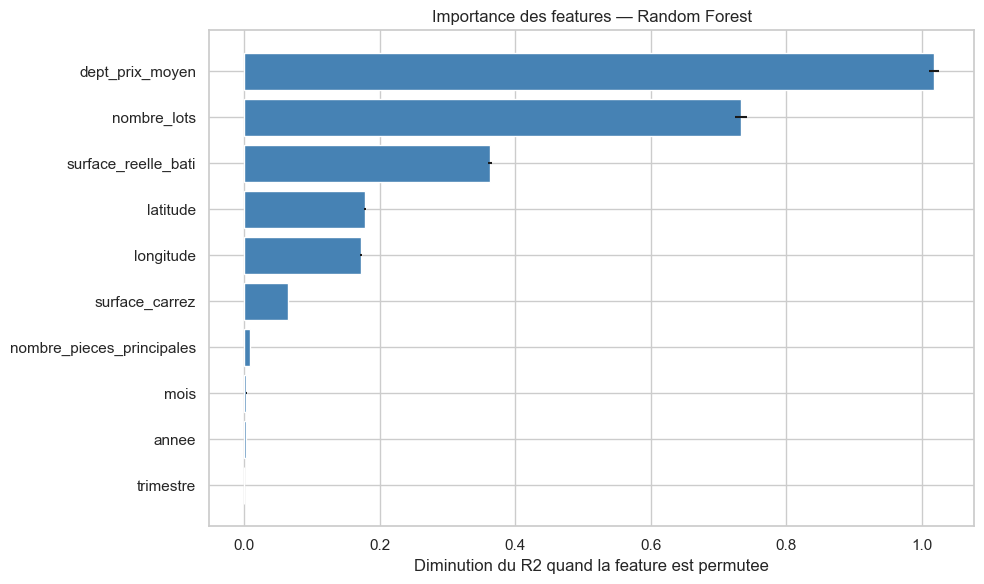

In [25]:
# Importance des features via permutation importance
perm_imp = permutation_importance(
    best_model, X_test, y_test,
    n_repeats=5, random_state=42, n_jobs=-1,
)

imp_df = pd.DataFrame({
    "feature": FEATURES,
    "importance_mean": perm_imp.importances_mean,
    "importance_std": perm_imp.importances_std,
}).sort_values("importance_mean", ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(imp_df["feature"], imp_df["importance_mean"], xerr=imp_df["importance_std"], color="steelblue")
ax.set_title(f"Importance des features — {best_result['modele']}")
ax.set_xlabel("Diminution du R2 quand la feature est permutee")
plt.tight_layout()
plt.show()

## 9. Conclusion

**Resume du pipeline** :
1. Chargement de 6 annees de donnees DVF (2020-2025)
2. Filtrage sur les ventes d'appartements, nettoyage des valeurs aberrantes et deduplication
3. Feature engineering : extraction temporelle, surface Carrez, target encoding du departement
4. Entrainement de 5 modeles : Regression Lineaire, Ridge, Lasso, Random Forest, HistGradientBoosting
5. Evaluation via MAE, RMSE, R2 et validation croisee 5-fold

**Observations** :
- La **localisation** (longitude, latitude, prix moyen du departement) et la **surface** sont les features les plus importantes
- Le modele **HistGradientBoosting** offre generalement les meilleures performances sur ce type de donnees tabulaires
- Les modeles lineaires servent de baseline utile mais capturent moins bien les non-linearites du marche immobilier

**Pistes d'amelioration** :
- Enrichir avec des donnees externes (revenus par commune, proximite transports, etc.)
- Target encoding plus sophistique (avec regularisation / cross-validation)
- Optimisation des hyperparametres (GridSearch / Optuna)
- Stacking de modeles